In [1]:
clear all;
clc

### Reading data

In [2]:
Data20F     = readtable('Data.csv');
startDate   = datenum('08-03-2017');  % This is the first day in our sample
endDate     = datenum('01-31-2023');  % This is the last day in our sample
xData       = linspace(startDate, endDate, height(Data20F(end-1382:end,1)));
xData       = datenum(xData);

In [3]:
benchmark    = table2array(Data20F(end-1382:end,2));
factors      = table2array(Data20F(end-1382:end,4:23));

### Defining key functions for portfolio construction

In [4]:
% Here we compute the optimal weights of factors

function theta = calculate_theta(benchmark, factors, M, np, gam)

    T   = size(benchmark, 1);    % Total lenght
    nf  = size(factors, 2);      % Defining the number of factors
    B   = 0.8;                   % B measures how much in terms of the wealth is invested in factors

    % We are using a third dimension to save our portoflios
    theta   = NaN(nf, T-M, np);  % 3D array for factor weights

    X0  = 0 * ones(nf, 1);
    A   = ones(1, nf);
    Aeq = [];
    Beq = [];
    LB  = zeros(1, nf);
    UB  = Inf(1, nf);

    warning off
    options = optimoptions('fmincon', 'Display', 'off', 'Algorithm', 'sqp');

    for i = 1:T-M

        t0  = i;
        t   = M + i - 1;

        benchmark_est = benchmark(t0:t);
        factors_est = factors(t0:t, :);

        % Mean variance portfolio.
        mean_var        = @(theta) - (mean(benchmark_est + factors_est * theta) ...
                                 - gam/2 * std(benchmark_est + factors_est * theta));
        theta(:, i, 1)  = fmincon(mean_var, X0, A, B, Aeq, Beq, LB, UB, [], options);

        % Minimum variance portfolio.
        min_var         = @(theta) std(benchmark_est + factors_est * theta);
        theta(:, i, 4)  = fmincon(min_var, X0, A, B, Aeq, Beq, LB, UB, [], options);

        % Bayes–Stein mean variance portfolio (mean shrinkage).
        % We use average return on sample minimum variance
        % portfolio (u_min_t) as a target.
        u_t = mean([benchmark_est, factors_est], 1)';
        u_min_t = mean([benchmark_est, factors_est], 1) * vertcat(1, reshape(theta(:, i, 4), [], 1));
        sigma = cov([benchmark_est, factors_est]);
        rho = (nf+3) / ( (nf+3) + M*(u_t - u_min_t)' * inv(sigma) * (u_t - u_min_t) );
        mean_hat = (1-rho) * u_t + rho * u_min_t;
        bs_mean_var = @(theta) - (mean_hat' * vertcat(1, theta) ...
                                   - gam/2 * std(benchmark_est + factors_est * theta));
        theta(:, i, 2)  = fmincon(bs_mean_var, X0, A, B, Aeq, Beq, LB, UB, [], options);

        % Ledoit-Wolf mean variance portfolio (covariance shrinkage).
        %rho = 0.5;
        sigma_hat = covarianceShrinkage([benchmark_est, factors_est]);
        %sigma_hat = (1-rho) * sigma + rho * mean(diag(sigma)) * eye(nf+1);
        lw_mean_var = @(theta) - (mean(benchmark_est + factors_est * theta) ...
                                   - gam/2 * sqrt(vertcat(1, theta)' * sigma_hat * vertcat(1, theta)) );
        theta(:, i, 3)  = fmincon(lw_mean_var, X0, A, B, Aeq, Beq, LB, UB, [], options);

        % CVar portfolio.
        theta(:, i, 5)  = CVaR(benchmark_est, factors_est, B, 0.05);

        % Naive portfolio.
        theta(:, i, 6)  = B / nf;

    end

end

In [5]:
function rp = calculate_returns(benchmark, factors, theta, M, np, include_tc)

    T    = size(benchmark, 1);  % Total lenght
    kapa = (50/10000)/21;       % Proportional transactions cost
    rp   = NaN(T-M, np);

    if include_tc == 0

        for portfolio = 1:np
            rp(:, portfolio) = ( benchmark(M+1:end,:) ...
                                 + sum(squeeze(theta(:,:,portfolio))'.*factors(M+1:end,:), 2) );
        end

    elseif include_tc == 1

        for portfolio = 1:np

            % We assume that portfolio formation (in the first period) has no cost
            rp(1,portfolio) = benchmark(M+1,:) + factors(M+1,:) * theta(:,1,portfolio) - kapa*0;

            for itime = 2:T-M
                w1      = theta(:, itime-1, portfolio)';
                w2      = theta(:, itime  , portfolio)';
                if sum((1+factors(M+itime-1,:)).*w1) ~= 0
                    w1 = ((1+factors(M+itime-1,:)).*w1) ./ sum((1+factors(M+itime-1,:)).*w1);
                elseif sum((1+factors(M+itime-1,:)).*w1) == 0
                    w1 = zeros(size(factors,2), 1)';
                end
                turnvec = sum(abs(w2-w1),2);
                rp(itime,portfolio) = ( benchmark(M+itime,:) ...
                                        + factors(M+itime,:) * theta(:,itime,portfolio) - kapa*turnvec);
                clear turnvec
            end

        end

    end
end

In [6]:
% Here we compute Ulcer index

function ulcer_index = calculate_ulcer_index(rp)

    cumulative_rp = exp(cumsum(log(1+rp)));
    cumulative_max = cummax(cumulative_rp);
    drawdowns = (cumulative_max - cumulative_rp) ./ cumulative_max;
    ulcer_index = sqrt(mean(drawdowns .^ 2));

end

In [7]:
% Now we compute the sharpe ratios and other performance
% measures of our portfolio strategies

function calculate_metrics(rp)

    portfolio_names = {'Mean-variance portfolio';
                       'BS Mean-variance portfolio';
                       'LW Mean-variance portfolio';
                       'Minimum-variance portfolio';
                       'CVaR portfolio';
                       '1/N portfolio'};

    for p_num = 1:length(portfolio_names)

        MN    = mean(rp(:,p_num)) * 252;
        SD    = std(rp(:,p_num)) *sqrt(252);
        SR    = (mean(rp(:,p_num))/std(rp(:,p_num))) *sqrt(252);
        MDD   = maxdrawdown(exp(cumsum(log(1+rp(:,p_num)))));
        UI    = calculate_ulcer_index(rp(:,p_num)) *sqrt(252);
        SW    = skewness(rp(:,p_num));

        fprintf(['-----' portfolio_names{p_num} '-----\n'])
        fprintf('Mean = %4.3f \n', MN)
        fprintf('Std = %4.3f \n', SD)
        fprintf('Sharpe ratio = %4.3f \n', SR)
        fprintf('MDD = %4.3f \n', MDD)
        fprintf('UI = %4.3f \n', UI)
        fprintf('Skewness = %4.3f \n', SW)

    end

end


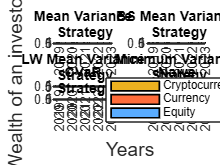

In [8]:
% Here we define a function that computes and plots
% the cumulative returns of the portfolio

function plot_comulative_returns(xData, r_benchmark, rp_with_factors, M, name)

    figure;
    plot(xData(M+1:end), exp(cumsum(log(1+r_benchmark))), 'LineWidth', 1.5);
    hold on
    plot(xData(M+1:end), exp(cumsum(log(1+rp_with_factors(:,1)))),'-m', 'LineWidth', 1.5)
    plot(xData(M+1:end), exp(cumsum(log(1+rp_with_factors(:,2)))),'-b', 'LineWidth', 1.5)
    plot(xData(M+1:end), exp(cumsum(log(1+rp_with_factors(:,3)))),'-r', 'LineWidth', 1.5)
    plot(xData(M+1:end), exp(cumsum(log(1+rp_with_factors(:,4)))),'-y', 'LineWidth', 1.5)
    plot(xData(M+1:end), exp(cumsum(log(1+rp_with_factors(:,5)))),'-k', 'LineWidth', 1.5)
    plot(xData(M+1:end), exp(cumsum(log(1+rp_with_factors(:,6)))),'-g', 'LineWidth', 1.5)
    datetick('x', 'yyyy', 'keeplimits')
    recessionplot
    axis([xData(M+1) xData(end) -inf inf])
    xlabel('Years');
    ylabel('Wealth of an investor,  !!!EQ_1!!! ')
    title([port_names(p),' Strategy'])
end
legend('Equity', 'Currency', 'Cryptocurrency', 'Location', 'best')


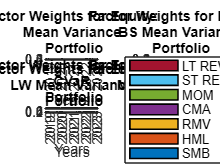

In [9]:
plot_factor_thetas(xData, equity_factor_names, port_names, ...
                       np, theta_all_factors(1:7,:,:), M, 'Factor Weights for Equity: ')


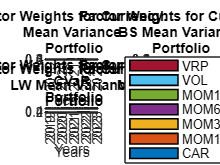

In [10]:
plot_factor_thetas(xData, currency_factor_names, port_names, ...
                       np, theta_all_factors(8:14,:,:), M, 'Factor Weights for Currency: ')


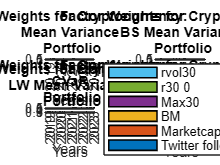

In [11]:
plot_factor_thetas(xData, crypto_factor_names, port_names, ...
                       np, theta_all_factors(15:20,:,:), M, 'Factor Weights for Cryptocurrency: ')

### Analysing Sharpe ratio dynamics

In [12]:
function sharpe_ratios = compute_SRs_dynamics(portfolio_returns, window_size, np)

    T = size(portfolio_returns, 1);
    sharpe_ratios = NaN(T-window_size, np);

    for i = 1:T-63

        t0  = i;
        t   = window_size + i - 1;

        rp_est = portfolio_returns(t0:t, :);

        rp_mean = mean(rp_est);
        rp_std  = std(rp_est);
        sharpe_ratios(i, :)  = (rp_mean ./ rp_std) * sqrt(window_size);

    end

end


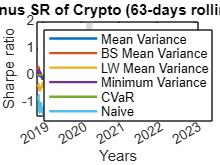

In [13]:
window_size = 63;   % Equivalent to 3 months
MV_crypto_SRs = compute_SRs_dynamics(rp_crypto, window_size, np);
MV_equity_and_crypto_SRs = compute_SRs_dynamics(rp_equity_crypto, window_size, np);

figure;
plot(xData(M+1+window_size:end), MV_equity_and_crypto_SRs - MV_crypto_SRs, 'LineWidth', 1.5);
hold on
datetick('x', 'yyyy', 'keeplimits')
recessionplot
axis([xData(M+1+window_size) xData(end) -inf inf])
xlabel('Years');
ylabel('Sharpe ratio')
title(append('SR of Equity + Crypto minus SR of Crypto (63-days rolling window, mean-variance)'))
legend(port_names, 'Location', 'Northwest', 'FontSize', 8)

### Saving results to xlsx files

In [14]:
function save_rp_to_xlsx(portfolio_returns, name, port_names, Date)

    rp_table = array2table(portfolio_returns, 'VariableNames', port_names);
    rp_table.Date = Date;
    rp_table = rp_table(:,[end 1:end-1]);
    filename = ['Returns/', name,' portfolios.xlsx'];
    writetable(rp_table, filename, 'Sheet', name);

end

In [15]:
function save_thetas_to_xlsx(portfolio_thetas, name, port_names, factor_names, np, Date)

    filename = ['Thetas/', name, ' thetas.xlsx'];

    for p = 1:np
        theta_table = array2table(portfolio_thetas(:,:,p)', 'VariableNames', factor_names);
        theta_table.Date = Date;
        theta_table = theta_table(:,[end 1:end-1]);
        sheetname = port_names{p};
        writetable(theta_table, filename, 'Sheet', sheetname);
    end

end

In [16]:
portfolio_returns = {rp_equity; rp_currency; rp_crypto;
                    rp_equity_currency; rp_equity_crypto; rp_currency_crypto;
                    rp_all_factors};

portfolio_thetas = {theta_equity; theta_currency; theta_crypto;
                    theta_equity_currency; theta_equity_crypto; theta_currency_crypto;
                    theta_all_factors};

file_names = {'Equity'; 'Currency'; 'Cryptocurrency';
              'Equity and currency'; 'Equity and cryptocurrency'; 'Currency and cryptocurrency';
              'All three asset classes'};

for p = 1:size(portfolio_returns)
    save_rp_to_xlsx(portfolio_returns{p}, file_names{p}, port_names, Data20F.DATE(M+1:end));
end

In [17]:
factor_names = {equity_factor_names; currency_factor_names; crypto_factor_names;
                [equity_factor_names; currency_factor_names];
                [equity_factor_names; crypto_factor_names];
                [currency_factor_names; crypto_factor_names]
                [equity_factor_names; currency_factor_names; crypto_factor_names]};

for p = 1:size(portfolio_thetas)
    save_thetas_to_xlsx(portfolio_thetas{p}, file_names{p}, port_names, ...
                        factor_names{p}, np, Data20F.DATE(M+1:end));
end